# Julia is fast

Original notebook is at the address: https://github.com/JuliaAcademy/JuliaTutorials/blob/main/introductory-tutorials/intro-to-julia/09.%20Julia%20is%20fast.ipynb

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.21562492484489126
 0.9940414293133066
 0.9613007781007851
 0.36934986366011524
 0.9022458130362258
 0.015036408270642676
 0.5969824106342801
 0.5670217464082639
 0.2651479882181683
 0.5697002224322107
 ⋮
 0.20237348448367853
 0.5183094390136759
 0.130760179756082
 0.58570810137729
 0.13905924768081557
 0.4181649091697315
 0.8966887046528882
 0.17515302644564157
 0.02084786675209571

In [2]:
sum(a)

5.000027810468748e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.004310 seconds (1 allocation: 16 bytes)


5.000027810468748e6

In [4]:
@time sum(a)

  0.004015 seconds (1 allocation: 16 bytes)


5.000027810468748e6

In [5]:
@time sum(a)

  0.006188 seconds (1 allocation: 16 bytes)


5.000027810468748e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
# using Pkg
# Pkg.add("BenchmarkTools")

In [8]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [9]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [10]:
c_sum(a)

5.000027810468334e6

In [11]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [12]:
c_sum(a) - sum(a)  

-4.1443854570388794e-7

In [13]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 481 samples with 1 evaluation.
 Range (min … max):  10.275 ms …  11.011 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.349 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.388 ms ± 118.660 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁▄▅████▇▆▆▆▄▄▂▁▁                                             
  ▆████████████████▇▇█▇▄▇▄▆▆▄▄▄▆▄▇▆▄▄▁▆▄▄▁▄▄▁█▄▄▆█▄▄▆▄▄▇▄▁▁▄▁▇ █
  10.3 ms       Histogram: log(frequency) by time      10.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 10.2747 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 10.2747

In [18]:
using Plots
gr()

Plots.GRBackend()

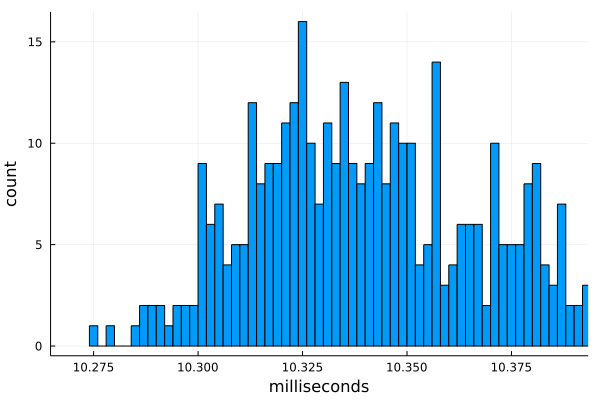

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [20]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 836 samples with 1 evaluation.
 Range (min … max):  5.822 ms …   7.254 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.932 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.980 ms ± 162.601 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄█▆█▇▇▇▇▆▄▁▁                                                
  ▆██████████████▆▅▆▄▄▅▄▃▃▅▄▃▃▄▃▃▃▃▃▂▃▃▂▃▃▃▂▃▂▃▁▃▃▁▂▃▂▁▂▁▁▂▁▂ ▄
  5.82 ms         Histogram: frequency by time        6.58 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

5.8217

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [23]:
# using Pkg; Pkg.add("PyCall")
using PyCall

In [24]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [26]:
pysum(a)

5.000027810468334e6

In [27]:
pysum(a) ≈ sum(a)

true

In [28]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  626.419 ms … 633.671 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     629.036 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   629.198 ms ±   2.168 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █        █    █     █  ██        █                          █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁█▁▁██▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  626 ms           Histogram: frequency by time          634 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [29]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 10.2747
  "Python built-in" => 626.419
  "C -ffast-math"   => 5.8217

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [31]:
# using Pkg; Pkg.add("Conda")
using Conda

In [34]:
Conda.add("numpy")

Solving environment: ...working... done

# All requested packages already installed.



┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda C:\Users\ilker.arslan\.julia\packages\Conda\sNGum\src\Conda.jl:128


In [35]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 539 samples with 1 evaluation.
 Range (min … max):  9.051 ms …  10.277 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.238 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.271 ms ± 160.254 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▂▆▄▃▆▆▅█▄▄▄▃                                             
  ▄▅▆▇████████████▆▆█▆▃▆▄▄▄▃▃▃▃▃▃▃▂▃▂▁▁▃▁▂▁▁▁▁▂▁▂▁▃▂▁▁▂▁▁▂▁▁▂ ▄
  9.05 ms         Histogram: frequency by time          10 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [36]:
numpy_sum(a)

5.00002781046875e6

In [37]:
numpy_sum(a) ≈ sum(a)

true

In [38]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 10.2747
  "Python numpy"    => 9.051
  "Python built-in" => 626.419
  "C -ffast-math"   => 5.8217

# 5. Python, hand-written 

In [39]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x00000000ABEC8D30>

In [40]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.000 s …   1.080 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.073 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.053 s ± 35.215 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁                      ▁                            ▁   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  1 s            Histogram: frequency by time        1.08 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [41]:
sum_py(a)

5.000027810468334e6

In [42]:
sum_py(a) ≈ sum(a)

true

In [43]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 10.2747
  "Python numpy"        => 9.051
  "Python hand-written" => 1000.39
  "Python built-in"     => 626.419
  "C -ffast-math"       => 5.8217

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [44]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:889

In [45]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 853 samples with 1 evaluation.
 Range (min … max):  4.041 ms … 10.823 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.606 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.846 ms ±  1.240 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▇▇▃█▆▄ ▄▃▄▅▁  ▃▃ ▃▂  ▃  ▁▂           ▁                   
  ▃▅███████▇█████▇██████▆▆█▅▇███▆▆▆█▇▅▅▇▅▇█▄▅▃▆▄▄▃▂▃▃▂▃▃▂▄▁▃ ▅
  4.04 ms        Histogram: frequency by time        9.14 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [46]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 10.2747
  "Python numpy"        => 9.051
  "Python hand-written" => 1000.39
  "Python built-in"     => 626.419
  "Julia built-in"      => 4.0413
  "C -ffast-math"       => 5.8217

# 7. Julia (hand-written) 

In [47]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [48]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 367 samples with 1 evaluation.
 Range (min … max):  10.656 ms … 20.722 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     13.307 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.640 ms ±  1.853 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▃▄▄ ▂▃▂▅▄▆▃▂ ▃▇█▅▁▂ ▂   ▂ ▃  ▂  ▁                       
  ▅▇▄▆▆███▇█████████████████▇█▆█▄█▆▆█▅▆██▅▄▅▄▄▄▄▆▆▆▄▃▄▄▃▁▃▄▄▅ ▅
  10.7 ms         Histogram: frequency by time        18.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [49]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 10.2747
  "Python numpy"        => 9.051
  "Julia hand-written"  => 10.6563
  "Python hand-written" => 1000.39
  "Python built-in"     => 626.419
  "Julia built-in"      => 4.0413
  "C -ffast-math"       => 5.8217

# 8. Julia (hand-written w. simd) 

In [50]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [51]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 620 samples with 1 evaluation.
 Range (min … max):  5.522 ms …  11.636 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.047 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.045 ms ± 677.046 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                               ▂▄▂█▁▆▇▄▅▅▃                     
  ▃▁▁▁▁▁▂▂▃▃▃▁▂▂▂▃▃▄▃▃▄▄▄▇▅▄▆▇████████████▆▆▆▇▆▄▆▆▄▅▃▃▃▃▃▂▃▂▃ ▄
  5.52 ms         Histogram: frequency by time        9.79 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [52]:
mysum_simd(a)

5.000027810468776e6

In [53]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 5.5216
  "C"                       => 10.2747
  "Python numpy"            => 9.051
  "Julia hand-written"      => 10.6563
  "Python hand-written"     => 1000.39
  "Python built-in"         => 626.419
  "Julia built-in"          => 4.0413
  "C -ffast-math"           => 5.8217

# Summary

In [54]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............4.0
Julia hand-written simd.....5.5
C -ffast-math...............5.8
Python numpy................9.1
C..........................10.3
Julia hand-written.........10.7
Python built-in...........626.4
Python hand-written......1000.4
